In [1]:
state = 'NM' 
year = 2020
obj_type = 'average_Polsby_Popper'
starting_deviation = 0.01 

In [2]:
import sys, os
src_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(src_path)

In [3]:
filepath = '../../dat/' + str(year) + '/'
filename = state + '_county.json'
filename2 = state + '_county.shp'

In [4]:
from read import read_graph_from_json

G = read_graph_from_json(state, filepath + filename, year=year)
print(f"The state of {state} has {G._k} districts.")
G._ideal_population = sum(G.nodes[i]['TOTPOP'] for i in G.nodes) / G._k

The state of NM has 3 districts.


In [5]:
#import warm starts
sys.path.append(os.path.abspath('../heuristic'))

from NM_plans_2020 import plans
print(f"Loaded {len(plans)} plans from file.")
warm_starts = plans

Loaded 149 plans from file.


In [6]:
from pareto import filter_and_sort_pareto
from metrics import scores

plans_scores = [scores(G, plan, G._ideal_population, obj_type) for plan in warm_starts]
_,_,nondominated_warm_starts_plans = filter_and_sort_pareto(plans=warm_starts, upper_bounds=plans_scores, obj_type=obj_type)
print(f"Selected {len(nondominated_warm_starts_plans)} nondominated warm start plans")

Selected 5 nondominated warm start plans


In [7]:
from epsilon_constraint import epsilon_constraint_method

(plans, obj_bounds, deviations) = epsilon_constraint_method(
            G,                 
            obj_type,          
            contiguity = 'lcut',                                             # {'lcut', 'scf', 'shir'} 
            cutoff=None,       
            verbose= True,
            warm_start_mode = 'user',                                        # {'None', 'user', 'refinement'}
            warm_starts=warm_starts,                                         # if you have user define warm starts else it is None
            starting_deviation=starting_deviation, 
            time_limit=7200, 
            sizes=None,      
            max_B=True,                                                      # If symmetry_breaking is 'orbitope' or you have warm_start, max_B should be True   
            symmetry_breaking='orbitope',                                    # {None, 'orbitope', 'rsum'} 
            state=state,
            year=year
        )

Initially, L = 698783 and U = 712899 and k = 3.

****************************************
Trying deviation = 7058.406666666667
****************************************
Using user-provided warm starts.
Selected warm_start = [[13, 25], [1, 3, 5, 6, 9, 10, 14, 15, 16, 17, 18, 22, 26, 28, 29, 32], [0, 2, 4, 7, 8, 11, 12, 19, 20, 21, 23, 24, 27, 30, 31]]
Objective value: 0.43342041766639655
Deviation: 5433.333333333372

****************************************
Running labeling model!
****************************************
L = 698783 and U = 712899 and k = 3
Set parameter Username
Set parameter LicenseID to value 2608266
Academic license - for non-commercial use only - expires 2026-01-09
sizes =  [1, 1, 1]
Solving the max B problem (as MIP) for use in the vertex ordering...
Set parameter LogToConsole to value 0
Set parameter LazyConstraints to value 1
Applying warm start!
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set p

Thread count was 20 (of 20 available processors)

Solution count 3: 0.425766 0.401067 0.3594 
No other solutions better than 0.425766

Optimal solution found (tolerance 0.00e+00)
Best objective 4.257659912109e-01, best bound 4.257659912109e-01, gap 0.0000%

User-callback calls 18983, time in user-callback 0.07 sec

****************************************
Optimal solution found! Gurobi status: 2
****************************************
plan = [[13, 18, 25], [1, 3, 5, 6, 9, 10, 14, 15, 16, 17, 22, 26, 28, 29, 32], [0, 2, 4, 7, 8, 11, 12, 19, 20, 21, 23, 24, 27, 30, 31]]

****************************************
Trying deviation = 3208.4999999999613
****************************************
Using user-provided warm starts.
Selected warm_start = [[13, 18, 25], [1, 3, 5, 6, 9, 10, 14, 15, 17, 22, 26, 28, 29, 32], [0, 2, 4, 7, 8, 11, 12, 16, 19, 20, 21, 23, 24, 27, 30, 31]]
Objective value: 0.415501415678718
Deviation: 1510.6666666666279

****************************************
Running labe

     0     2    0.94779    0  230    0.35677    0.94779   166%     -    0s
  9980  1637    0.41580   36   27    0.35677    0.42642  19.5%  42.7    5s
 35178  1759 infeasible   35         0.35677    0.37500  5.11%  35.0   10s

Explored 48482 nodes (1643303 simplex iterations) in 12.64 seconds (7.75 work units)
Thread count was 20 (of 20 available processors)

Solution count 3: 0.356771 0.355463 0.345046 
No other solutions better than 0.356771

Optimal solution found (tolerance 0.00e+00)
Best objective 3.567714691162e-01, best bound 3.567714691162e-01, gap 0.0000%

User-callback calls 98670, time in user-callback 0.36 sec

****************************************
Optimal solution found! Gurobi status: 2
****************************************
plan = [[13, 18, 25], [0, 1, 3, 4, 6, 9, 10, 12, 14, 16, 17, 20, 22, 26, 28, 29, 32], [2, 5, 7, 8, 11, 15, 19, 21, 23, 24, 27, 30, 31]]

****************************************
Trying deviation = 1354.1666666667054
*******************************

In [8]:
result = list(zip(plans, obj_bounds , deviations))

In [9]:
epsilon = 1 / (2 * G._k)
min_deviation = min(round(r[2], 1) for r in result)

if min_deviation < epsilon:
    no_solution_region = None
else:
    no_solution_region = [0, min_deviation]

if no_solution_region is not None:
    print(f"No feasible solution was found within the region: {no_solution_region}")

No feasible solution was found within the region: [0, 1354.3]



####################################################################################################
Pareto Frontier for state NM,  objective average_Polsby_Popper
####################################################################################################

Pareto front plans: [[[13, 18, 25], [0, 1, 3, 4, 6, 9, 10, 12, 14, 16, 17, 20, 22, 26, 28, 29, 32], [2, 5, 7, 8, 11, 15, 19, 21, 23, 24, 27, 30, 31]], [[13, 18, 25], [1, 3, 5, 6, 9, 10, 14, 15, 17, 22, 26, 28, 29, 32], [0, 2, 4, 7, 8, 11, 12, 16, 19, 20, 21, 23, 24, 27, 30, 31]], [[13, 18, 25], [1, 3, 5, 6, 9, 10, 14, 15, 16, 17, 22, 26, 28, 29, 32], [0, 2, 4, 7, 8, 11, 12, 19, 20, 21, 23, 24, 27, 30, 31]], [[13, 25], [1, 3, 5, 6, 9, 10, 14, 15, 16, 17, 18, 22, 26, 28, 29, 32], [0, 2, 4, 7, 8, 11, 12, 19, 20, 21, 23, 24, 27, 30, 31]]]
Pareto front upper bounds: [[1354.3333333333721, 0.35677146911621094], [1510.6666666666279, 0.4155009589855069], [3208.666666666628, 0.4257659912109375], [5433.333333333372, 0.4334198633829752

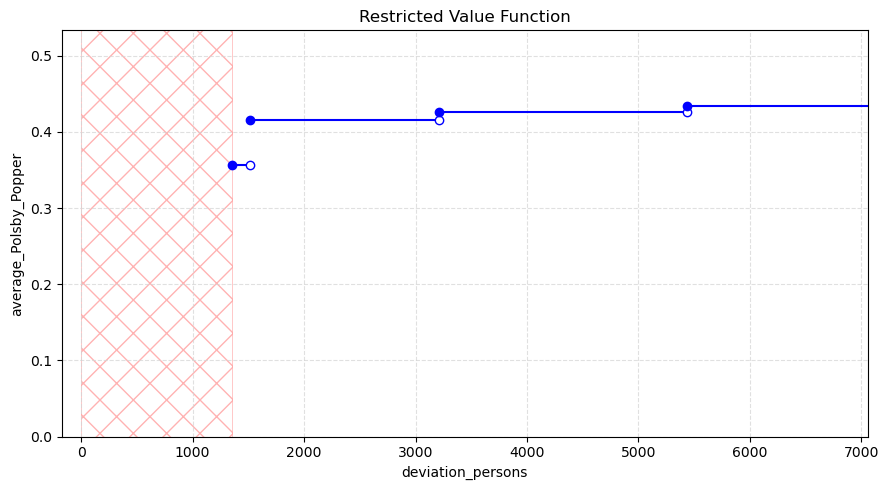

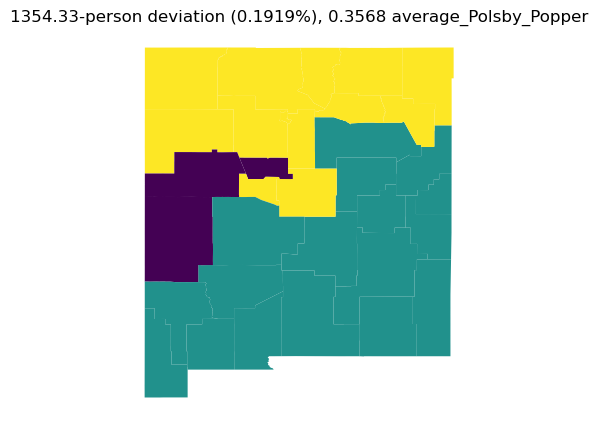

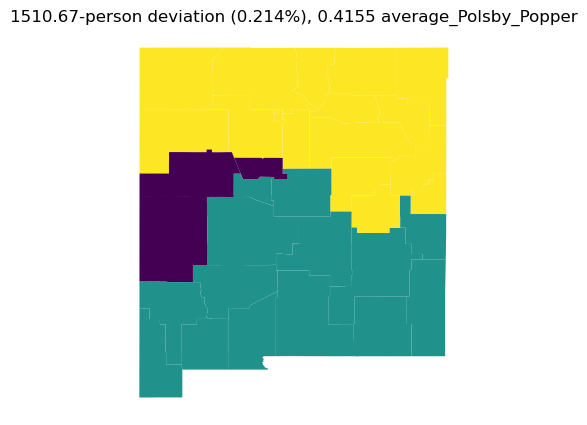

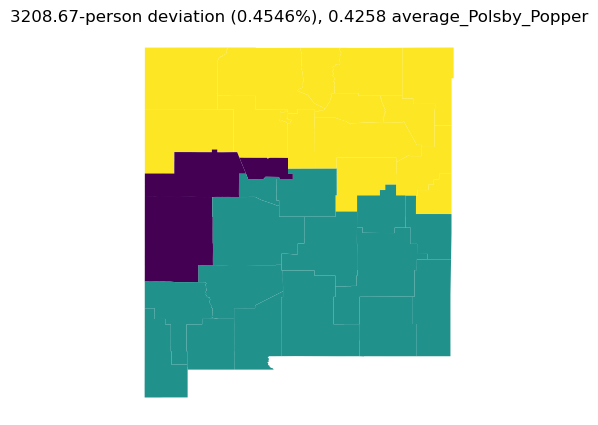

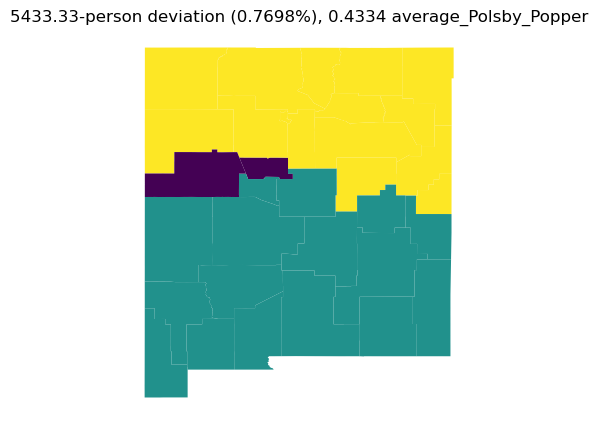

In [10]:
from pareto import plot_pareto_frontiers

plot_pareto_frontiers(
                G,
                method='epsilon_constraint_method',
                plans=None,                                   #if method ='epsilon_constraint_method' is None 
                obj_types=obj_type,                               
                ideal_population=G._ideal_population,
                state=state,
                filepath=filepath,
                filename2=filename2,
                no_solution_region=no_solution_region,
                year=year,
                result=result                               #if method ='heuristic' is None 
             )